In [ ]:
import kagglehub
import pandas as pd

# Download latest version
path = kagglehub.dataset_download("blastchar/telco-customer-churn")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'telco-customer-churn' dataset.
Path to dataset files: /kaggle/input/telco-customer-churn


In [ ]:
customer_df = pd.read_csv("/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [ ]:
pd.set_option("display.max_columns", None)
customer_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Taking the feature `Payment Method`

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


In [ ]:
customer_df['PaymentMethod'].unique()

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

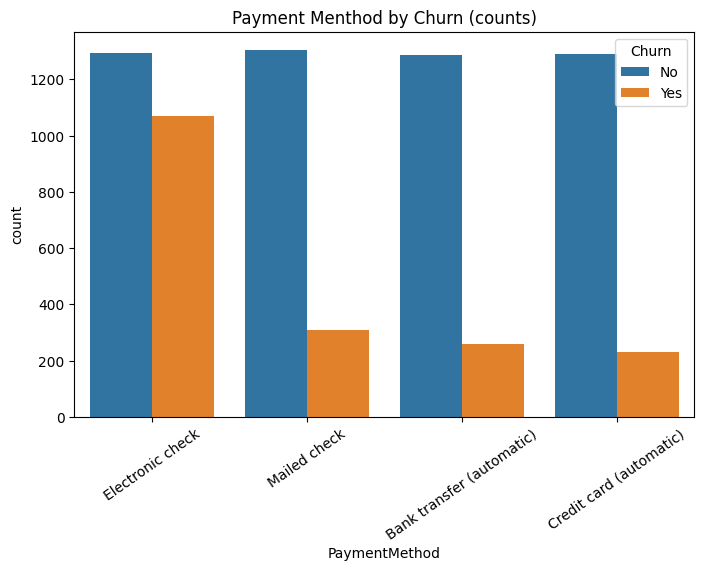

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(data=customer_df, x='PaymentMethod', hue='Churn')
plt.xticks(rotation=35)
plt.title("Payment Menthod by Churn (counts)")
plt.show()

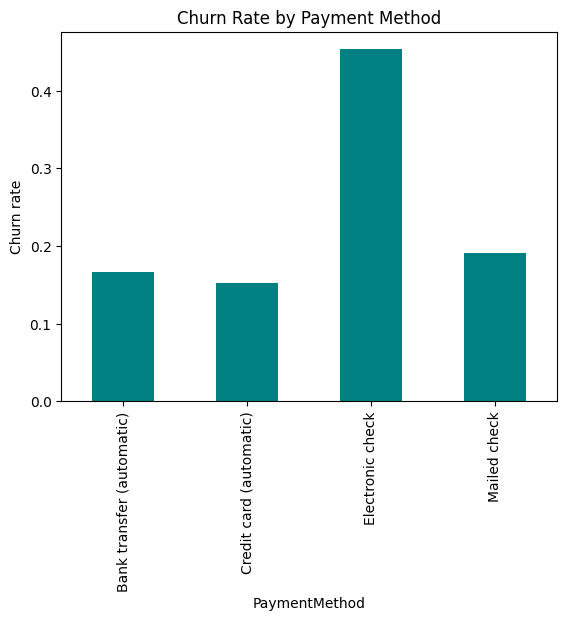

In [ ]:
pm_rate = customer_df.groupby('PaymentMethod')['Churn'].apply(lambda x: (x=='Yes').mean())
pm_rate.plot(kind='bar', color='teal')
plt.ylabel("Churn rate")
plt.title("Churn Rate by Payment Method")
plt.show()

In [ ]:
print("Payment Method to churn rate:",pm_rate)

Payment Method to churn rate: PaymentMethod
Bank transfer (automatic)    0.167098
Credit card (automatic)      0.152431
Electronic check             0.452854
Mailed check                 0.191067
Name: Churn, dtype: float64


## Statistical tests

### Contigency Table

In [ ]:
ct_pm = pd.crosstab(customer_df['PaymentMethod'], customer_df['Churn'])
ct_pm

Churn,No,Yes
PaymentMethod,,
Bank transfer (automatic),1286,258
Credit card (automatic),1290,232
Electronic check,1294,1071
Mailed check,1304,308


#### Chi2 test

As both variables are categorical.

The null hypothesis H0: The payment method and churn are independent

H1: The both are not independent

In [ ]:
from scipy.stats import chi2_contingency

chi2_pm, p_pm, dof_pm, expected_pm = chi2_contingency(ct_pm)
print("Chi2 for Payment Method by churn:", chi2_pm)
print("P value for payment method by churn:", p_pm)
print("Degrees of freedom for payment method by churn:", dof_pm)
print("Rejecting null hypothesis H0:", p_pm < 0.05)

Chi2 for Payment Method by churn: 648.1423274814
P value for payment method by churn: 3.6823546520097993e-140
Degrees of freedom for payment method by churn: 3
Rejecting null hypothesis H0: True


In [ ]:
print("Expected count (if independent): \n\n", expected_pm)

Expected count (if independent): 

 [[1134.26891949  409.73108051]
 [1118.10705665  403.89294335]
 [1737.40025557  627.59974443]
 [1184.22376828  427.77623172]]


From the chi2 test, paymentmethod and churn are dependent

### Effect size (Cramer's V)

In [ ]:
def cramersV(chi2, n, r, c):
  return np.sqrt(chi2 / n*(min(r-1, c-1)))

In [ ]:
n_pm = ct_pm.to_numpy().sum()
r_pm, c_pm = ct_pm.shape

V_pm = cramersV(chi2_pm, n_pm, r_pm, c_pm)
print("The Cramer's V:", V_pm)

The Cramer's V: 0.30335862555407056


From the Cramer's V, the strength of association is 0.3 which is moderate. So the paymentmethod may be a predictive feature

In [ ]:
ct_pm['total'] = ct_pm.sum(axis=1)
ct_pm['Churn rate'] = ct_pm['Yes'] / ct_pm['total']
ct_pm

Churn,No,Yes,total,Churn rate
PaymentMethod,,,,
Bank transfer (automatic),1286,258,1544,0.167098
Credit card (automatic),1290,232,1522,0.152431
Electronic check,1294,1071,2365,0.452854
Mailed check,1304,308,1612,0.191067


In [ ]:
from statsmodels.stats.proportion import proportion_confint

CI_pm = ct_pm.apply(lambda row: proportion_confint(row['Yes'], row['total'], method='wilson'),
                    axis=1)

ct_pm['CI Low'] = [c[0] for c in CI_pm]
ct_pm['CI High'] = [c[1] for c in CI_pm]

ct_pm

Churn,No,Yes,total,Churn rate,CI Low,CI High
PaymentMethod,,,,,,
Bank transfer (automatic),1286,258,1544,0.167098,0.149321,0.186528
Credit card (automatic),1290,232,1522,0.152431,0.135250,0.171362
Electronic check,1294,1071,2365,0.452854,0.432885,0.472976
Mailed check,1304,308,1612,0.191067,0.172618,0.210984


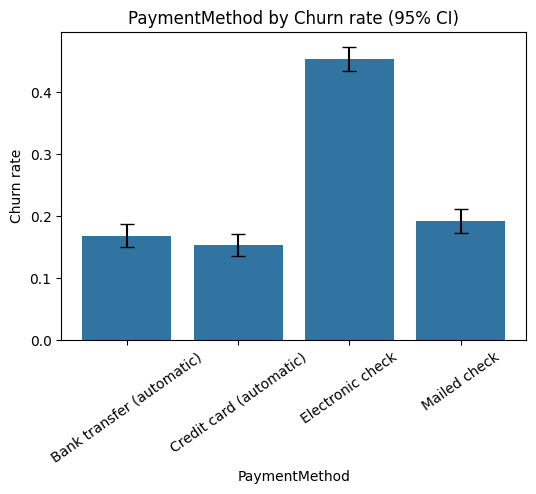

In [ ]:
plt.figure(figsize=(6,4))
sns.barplot(x=ct_pm.index, y=ct_pm['Churn rate'])
plt.errorbar(x=range(len(ct_pm)), y=ct_pm['Churn rate'],
             yerr=[ct_pm['Churn rate'] - ct_pm['CI Low'], ct_pm['CI High'] - ct_pm['Churn rate']],
             fmt='none', color='k', capsize=5)
plt.xticks(rotation=35)
plt.title("PaymentMethod by Churn rate (95% CI)")
plt.show()

###

### Pairwise proportion test

In [ ]:
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.multitest import multipletests

payments = ct_pm.index.to_list()
pairs = []
pvals = []
counts = []
nobs = []

for i in range(len(payments)):
  for j in range(i+1, len(payments)):
    pm1, pm2 = payments[i], payments[j]
    count = np.array([ct_pm.loc[pm1, 'Yes'], ct_pm.loc[pm2, 'Yes']])
    nobs_pair = np.array([ct_pm.loc[pm1, 'total'], ct_pm.loc[pm2, 'total']])
    stat_prop_pair, pairz_p = proportions_ztest(count, nobs_pair)
    pairs.append(f"{pm1} vs {pm2}")
    pvals.append(pairz_p)
    counts.append(count)
    nobs.append(nobs_pair)

### Adjsuted p-values using FDR

In [ ]:
rej, adj_p, _, _ = multipletests(pvals, method='fdr_bh')
results = pd.DataFrame({
    "pairs": pairs, "p value": pvals, "Reject null": rej, 'adjusted_p': adj_p,
    "count1": [c[0] for c in counts], 'n1': [n[0] for n in nobs],
    'count2': [c[1] for c in counts], 'n2': [n[1] for n in nobs]
})

results['p value'] = results['p value'].apply(lambda x: f"{x:.2e}")
results['adjusted_p'] = results['adjusted_p'].apply(lambda x: f"{x:.2e}")
results

,pairs,p value,Reject null,adjusted_p,count1,n1,count2,n2
0,Bank transfer (automatic) vs Credit card (auto...,2.68e-01,False,2.68e-01,258,1544,232,1522
1,Bank transfer (automatic) vs Electronic check,6.61e-76,True,1.98e-75,258,1544,1071,2365
2,Bank transfer (automatic) vs Mailed check,7.93e-02,False,9.52e-02,258,1544,308,1612
3,Credit card (automatic) vs Electronic check,1.49e-83,True,8.93e-83,232,1522,1071,2365
4,Credit card (automatic) vs Mailed check,4.20e-03,True,6.30e-03,232,1522,308,1612
5,Electronic check vs Mailed check,4.89e-65,True,9.79e-65,1071,2365,308,1612


From here, the Electronic check users have seemed high churn rate. By pairwise z test, Electronic check is still higher and very distinguishable from others. But the Bank vs Credit and bank vs Mail, had accepted the null hypothesis as there is no significant difference after correction multiple test. So may be that two be merged in order to better fits into one similar category by further tests. Only merging approves after the further tests are satisfied.

### Merge Bank and Credit as Automatic to further testing for similarity

In [ ]:
customer_df2 = customer_df.copy()
customer_df2['PaymentMethod'] = customer_df2['PaymentMethod'].replace({
    'Bank transfer (automatic)': 'Automatic',
    'Credit card (automatic)': 'Automatic',
    'Mailed check': 'Mailed check',
    'Electronic check': 'Electronic check'
})
customer_df2['PaymentMethod'].value_counts()

,count
PaymentMethod,
Automatic,3066
Electronic check,2365
Mailed check,1612


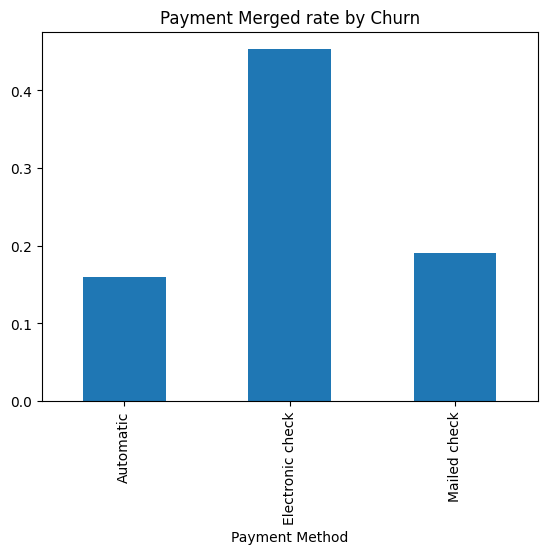

In [ ]:
merged_rate = customer_df2.groupby('PaymentMethod')['Churn'].apply(lambda x: (x=='Yes').mean())
merged_rate.plot(kind='bar')
plt.xlabel("Payment Method")
plt.title("Payment Merged rate by Churn")
plt.show()

### Contigency table for merged

In [ ]:
ct_merged = pd.crosstab(customer_df2['PaymentMethod'], customer_df2['Churn'])
ct_merged

Churn,No,Yes
PaymentMethod,,
Automatic,2576,490
Electronic check,1294,1071
Mailed check,1304,308


### Chi2 square

In [ ]:
chi2_merged, p_merged, dof_merged, expected_merged = chi2_contingency(ct_merged)
print("Chi2 value of merged:", chi2_merged, '\n')
print("degress of freedom value of merged:", dof_merged, '\n')
print("Pvalue of merged:", p_merged, '\n')
print("Expected value if independet:", expected_merged)
print("\nRejecting null hypothesis that of independent:", p_merged < 0.05)

Chi2 value of merged: 647.2965079283805 

degress of freedom value of merged: 2 

Pvalue of merged: 2.762798590247217e-141 

Expected value if independet: [[2252.37597615  813.62402385]
 [1737.40025557  627.59974443]
 [1184.22376828  427.77623172]]

Rejecting null hypothesis that of independent: True


In [ ]:
n_merged = ct_merged.to_numpy().sum()
r_merged, c_merged = ct_merged.shape
merged_V = cramersV(chi2_merged, n_merged, r_merged, c_merged)
print("Cramer's V for merged group:", merged_V)

Cramer's V for merged group: 0.3031606208785247


In [ ]:
print("Cramer's V for unmerged Payment method by Churn:", V_pm)
print("Cramer's V for merged Payment method by Churn:", merged_V)

Cramer's V for unmerged Payment method by Churn: 0.30335862555407056
Cramer's V for merged Payment method by Churn: 0.3031606208785247


So, here it is noted that there is dependency for Merged new feature and churn. By looking into Cramer's V to check the strength of both looks similar as the value is 0.3 of moderate association. To confirm it checking the pairwise test to follow up

### 95% CI (wilson)

In [ ]:
ct_merged['total'] = ct_merged.sum(axis=1)
ct_merged['Churn rate'] = ct_merged['Yes'] / ct_merged['total']
ct_merged

Churn,No,Yes,total,Churn rate
PaymentMethod,,,,
Automatic,2576,490,3066,0.159817
Electronic check,1294,1071,2365,0.452854
Mailed check,1304,308,1612,0.191067


In [ ]:
CI_merged = ct_merged.apply(lambda row: proportion_confint(row['Yes'], row['total'], method='wilson'),
                            axis=1)
ct_merged['CI Low'] = [c[0] for c in CI_merged]
ct_merged['CI High'] = [c[1] for c in CI_merged]
ct_merged

Churn,No,Yes,total,Churn rate,CI Low,CI High
PaymentMethod,,,,,,
Automatic,2576,490,3066,0.159817,0.147274,0.173213
Electronic check,1294,1071,2365,0.452854,0.432885,0.472976
Mailed check,1304,308,1612,0.191067,0.172618,0.210984


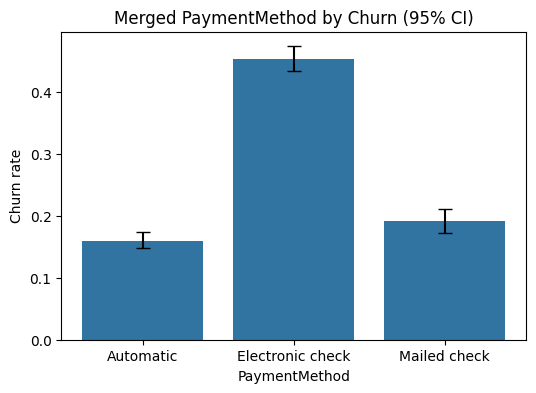

In [ ]:
plt.figure(figsize=(6,4))
sns.barplot(x=ct_merged.index, y=ct_merged['Churn rate'])
plt.errorbar(x=range(len(ct_merged)), y=ct_merged['Churn rate'],
             yerr=[ct_merged['Churn rate'] - ct_merged['CI Low'], ct_merged['CI High'] - ct_merged['Churn rate']],
             fmt='none', color='k', capsize=5)
plt.xlabel("PaymentMethod")
plt.title("Merged PaymentMethod by Churn (95% CI)")
plt.show()

### Pairwise pp test with multiple test adjsuted correction FDR

In [ ]:

payments_merged = ct_merged.index.to_list()
pairs_merged = []
pvals_merged = []
counts_merged = []
nobs_merged = []

for i in range(len(payments_merged)):
  for j in range(i+1, len(payments_merged)):
    pm1, pm2 = payments_merged[i], payments_merged[j]
    count = np.array([ct_merged.loc[pm1, 'Yes'], ct_merged.loc[pm2, 'Yes']])
    nobs_pair = np.array([ct_merged.loc[pm1, 'total'], ct_merged.loc[pm2, 'total']])
    stat_prop_pair_merged, pairz_p_merged = proportions_ztest(count, nobs_pair)
    pairs_merged.append(f"{pm1} vs {pm2}")
    pvals_merged.append(pairz_p_merged)
    counts_merged.append(count)
    nobs_merged.append(nobs_pair)

In [ ]:
rej_merged, adj_p_merged, _, _ = multipletests(pvals_merged, method='fdr_bh')
results_merged = pd.DataFrame({
    "pairs": pairs_merged, "p value": pvals_merged, "Reject null": rej_merged, 'adjusted_p': adj_p_merged,
    "count1": [c[0] for c in counts_merged], 'n1': [n[0] for n in nobs_merged],
    'count2': [c[1] for c in counts_merged], 'n2': [n[1] for n in nobs_merged]
})

results_merged['p value'] = results_merged['p value'].apply(lambda x: f"{x:.2e}")
results_merged['adjusted_p'] = results_merged['adjusted_p'].apply(lambda x: f"{x:.2e}")
results_merged

,pairs,p value,Reject null,adjusted_p,count1,n1,count2,n2
0,Automatic vs Electronic check,9.41e-124,True,2.82e-123,490,3066,1071,2365
1,Automatic vs Mailed check,6.93e-03,True,6.93e-03,490,3066,308,1612
2,Electronic check vs Mailed check,4.89e-65,True,7.34e-65,1071,2365,308,1612


From the pairwise tests with correction, it is clear that the merging of bank automatic and credit automatic into one Automatic sub category is fine. The churn behaviour between Credit and Bank is indistinguishable. It is statistically found that they are similar and can be merged as it is very distinguishable from other two sub categories. So merging can be done

### Merging the feature

In [ ]:
customer_df['PaymentMethod'] = customer_df['PaymentMethod'].replace({
    'Bank transfer (automatic)': 'Automatic',
    'Credit card (automatic)': 'Automatic',
    'Mailed check': 'Mailed check',
    'Electronic check': 'Electronic check'
})
customer_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Automatic,42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Checking on feature `InternetService`

In [ ]:
customer_df['InternetService'].unique()

array(['DSL', 'Fiber optic', 'No'], dtype=object)

In [ ]:
ct_is = pd.crosstab(customer_df['InternetService'], customer_df['Churn'], margins=True)
ct_is

Churn,No,Yes,All
InternetService,,,
DSL,1962,459,2421
Fiber optic,1799,1297,3096
No,1413,113,1526
All,5174,1869,7043


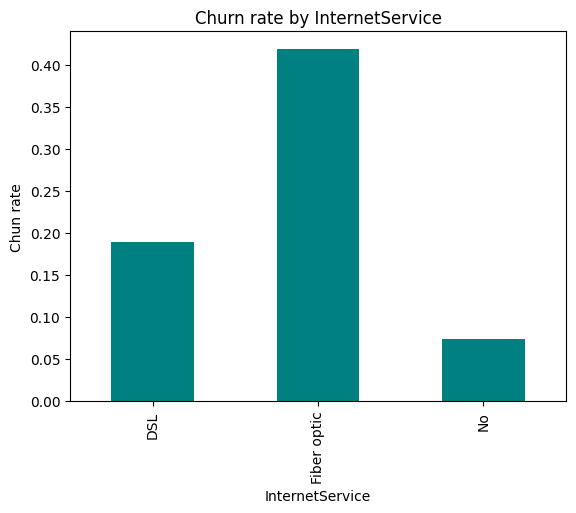

In [ ]:
churn_rate_is = customer_df.groupby("InternetService")['Churn'].apply(lambda x: (x=='Yes').mean())
churn_rate_is.plot(kind='bar', color='teal')
plt.xlabel("InternetService")
plt.ylabel("Chun rate")
plt.title("Churn rate by InternetService")
plt.show()

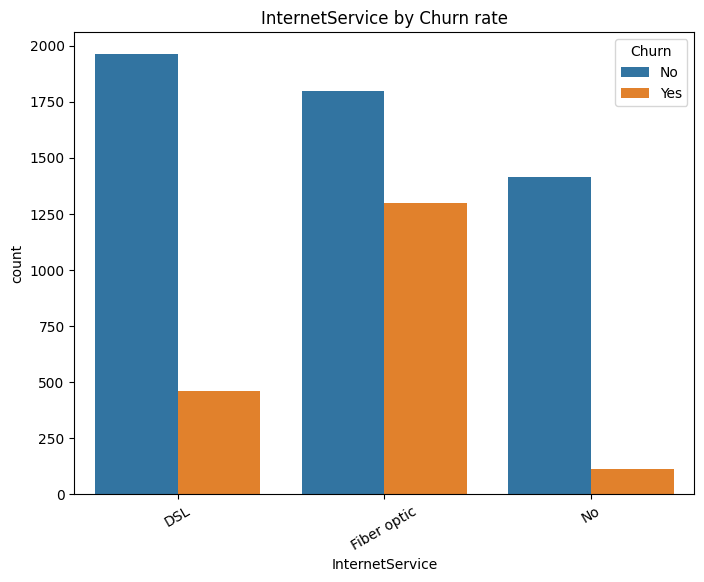

In [ ]:
plt.figure(figsize=(8,6))
sns.countplot(data=customer_df, x='InternetService', hue='Churn')
plt.xticks(rotation=30)
plt.title("InternetService by Churn rate")
plt.show()

### chi2 test

In [ ]:
chi2_is, p_is, dof_is, expected_is = chi2_contingency(ct_is.iloc[:-1, :-1])
print("Chi2  value:", chi2_is)
print("Pvalue of internetservice by churn rate:", p_is)
print("degrees of freedom:", dof_is)
print("\nExpected counts (if independent):\n", expected_is)
print("\nRejecting null hypothesis as the churn rate and internetservice is independent:", p_is < 0.05)

Chi2  value: 732.309589667794
Pvalue of internetservice by churn rate: 9.571788222840544e-160
degrees of freedom: 2

Expected counts (if independent):
 [[1778.53954281  642.46045719]
 [2274.41488002  821.58511998]
 [1121.04557717  404.95442283]]

Rejecting null hypothesis as the churn rate and internetservice is independent: True


In [ ]:
n_is = ct_is.iloc[:-1, :-1].to_numpy().sum()
r_is, c_is = ct_is.shape
is_V = cramersV(chi2_is, n_is, r_is, c_is)
is_V

np.float64(0.4560196052302312)

## Residuals

#### Pearson residuals

In [ ]:
def pearson_res(observed, expected):

  residual = (observed - expected) / np.sqrt(expected)
  return residual

#### HaberMan residuals (adjusted)

In [ ]:
def haberman_res(observed, expected,
                 row_total, col_total, N):
  adj_denom = np.sqrt(expected * (1 - (row_total/N)) * (1- (col_total/N)))
  std_res = (observed - expected) / adj_denom

  return std_res

In [ ]:
observed = ct_is.iloc[:-1, :-1].to_numpy()
row_total = observed.sum(axis=1)[:, None]
col_total = observed.sum(axis=0)[None, :]
N = observed.sum()

pearson_residuals = pearson_res(observed, expected_is)

std_residuals = haberman_res(observed, expected_is,
                             row_total, col_total, N)
print("Raw residuals:", pearson_residuals)
print("\nStandard Residuals:", std_residuals)

Raw residuals: [[  4.35021487  -7.23801152]
 [ -9.96868623  16.58618435]
 [  8.71973776 -14.50814828]]

Standard Residuals: [[ 10.42434499 -10.42434499]
 [-25.84981273  25.84981273]
 [ 19.12515527 -19.12515527]]


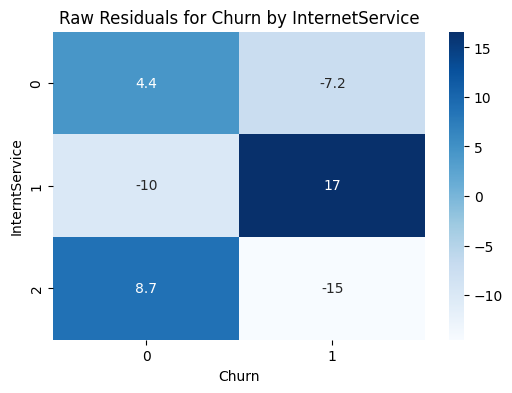

In [ ]:
plt.figure(figsize=(6,4))
sns.heatmap(data=pearson_residuals, annot=True, cmap='Blues')
plt.xlabel("Churn")
plt.ylabel("InterntService")
plt.title("Raw Residuals for Churn by InternetService")
plt.show()

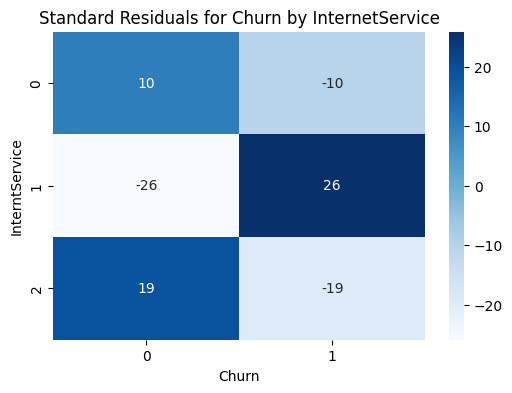

In [ ]:
plt.figure(figsize=(6,4))
sns.heatmap(data=std_residuals, annot=True, cmap='Blues')
plt.xlabel("Churn")
plt.ylabel("InterntService")
plt.title("Standard Residuals for Churn by InternetService")
plt.show()

### Taking contributers

In [ ]:
contrib = pearson_residuals ** 2
percet_contrib = contrib / contrib.sum() * 100
percet_contrib

array([[ 2.58420342,  7.15391572],
       [13.57004013, 37.56628551],
       [10.38274354, 28.74281169]])

In [ ]:
raw = ct_is.iloc[:-1, :-1].values - expected_is
raw

array([[ 183.46045719, -183.46045719],
       [-475.41488002,  475.41488002],
       [ 291.95442283, -291.95442283]])

In [ ]:
idx = ct_is.iloc[:-1, :-1]
raw_df = pd.DataFrame(raw, index=idx.index, columns=idx.columns)
std_res_df = pd.DataFrame(std_residuals, index=idx.index, columns=idx.columns)
contrib_df = pd.DataFrame(percet_contrib, index=idx.index, columns=idx.columns)

contrib_df

Churn,No,Yes
InternetService,,
DSL,2.584203,7.153916
Fiber optic,13.570040,37.566286
No,10.382744,28.742812


### taking top contributors with respect to chi square

In [ ]:
flat = contrib_df.stack().reset_index()
flat.columns = ['row', 'column', 'pct chi2']
flat = flat.sort_values('pct chi2', ascending=False)
flat

,row,column,pct chi2
3,Fiber optic,Yes,37.566286
5,No,Yes,28.742812
2,Fiber optic,No,13.570040
4,No,No,10.382744
1,DSL,Yes,7.153916
0,DSL,No,2.584203


### Paiwise test with correction for testing the sub categories

### CI for subcategories

In [ ]:
ct_is['Churn rate'] = ct_is['Yes'] / ct_is['All']
ct_is

Churn,No,Yes,All,Churn rate
InternetService,,,,
DSL,1962,459,2421,0.189591
Fiber optic,1799,1297,3096,0.418928
No,1413,113,1526,0.074050
All,5174,1869,7043,0.265370


In [ ]:
CI_is = ct_is.apply(lambda row: proportion_confint(row['Yes'], row['All'], method='wilson'),
                    axis=1)
CI_is_low = [c[0] for c in CI_is]
CI_is_high = [c[1] for c in CI_is]

In [ ]:
ct_is['CI low'] = CI_is_low
ct_is['CI High'] = CI_is_high
ct_is

Churn,No,Yes,All,Churn rate,CI low,CI High
InternetService,,,,,,
DSL,1962,459,2421,0.189591,0.174474,0.205692
Fiber optic,1799,1297,3096,0.418928,0.401659,0.436397
No,1413,113,1526,0.074050,0.061954,0.088284
All,5174,1869,7043,0.265370,0.255188,0.275807


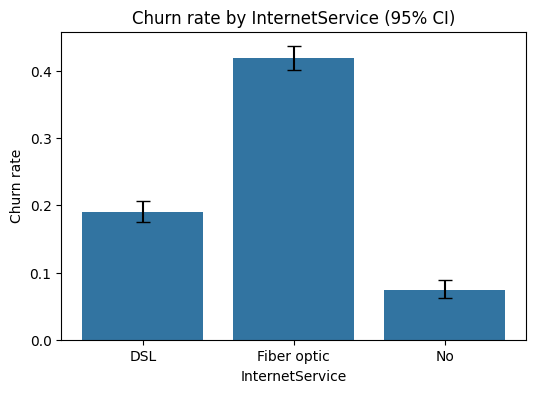

In [ ]:
plt.figure(figsize=(6,4))
sns.barplot(x=ct_is.index[:-1], y=ct_is['Churn rate'][:-1])
plt.errorbar(x=range(len(ct_is[:-1])), y=ct_is['Churn rate'][:-1],
             yerr=[ct_is['Churn rate'][:-1] - ct_is['CI low'][:-1], ct_is['CI High'][:-1] - ct_is['Churn rate'][:-1]],
             fmt='none', color='k', capsize=5)
plt.title("Churn rate by InternetService (95% CI)")
plt.show()

In [ ]:
int_ser = ct_is.index.to_list()
pairs_is = []
pvals_is = []
counts_is = []
nobs_is = []

for i in range(len(int_ser)):
  for j in range(i+1, len(int_ser)):
    p1_is, p2_is = int_ser[i], int_ser[j]
    count_is = np.array([ct_is.loc[p1_is, 'Yes'], ct_is.loc[p2_is, 'Yes']])
    nobs_pair_is = np.array([ct_is.loc[p1_is, 'All'], ct_is.loc[p2_is, 'All']])
    stat_prop_pair_is, pairz_p_is = proportions_ztest(count_is, nobs_pair_is)
    pairs_is.append(f"{p1_is} vs {p2_is}")
    pvals_is.append(pairz_p_is)
    counts_is.append(count_is)
    nobs_is.append(nobs_pair_is)

In [ ]:
rej_is, adj_p_is, _, _ = multipletests(pvals_is, method='fdr_bh')
results_is = pd.DataFrame({
    "pairs": pairs_is, "p value": pvals_is, "Reject null": rej_is, 'adjusted_p': adj_p_is,
    "count1": [c[0] for c in counts_is], 'n1': [n[0] for n in nobs_is],
    'count2': [c[1] for c in counts_is], 'n2': [n[1] for n in nobs_is]
})

results_is['p value'] = results_is['p value'].apply(lambda x: f"{x:.2e}")
results_is['adjusted_p'] = results_is['adjusted_p'].apply(lambda x: f"{x:.2e}")
results_is

,pairs,p value,Reject null,adjusted_p,count1,n1,count2,n2
0,DSL vs Fiber optic,1.35e-73,True,4.06e-73,459,2421,1297,3096
1,DSL vs No,9.99e-24,True,1.20e-23,459,2421,113,1526
2,DSL vs All,8.10e-14,True,8.10e-14,459,2421,1869,7043
3,Fiber optic vs No,9.80e-127,True,5.88e-126,1297,3096,113,1526
4,Fiber optic vs All,2.73e-53,True,4.10e-53,1297,3096,1869,7043
5,No vs All,4.22e-58,True,8.43e-58,113,1526,1869,7043


`InternetService` is a dependent and predictive feature for customer churning. It is estimated from chi2 square test. More churners occur in Fibre optic category of InternetService.
From the wilson CI, the Fibre optic has CI - [40,43], DSL has CI - [19,21], No group has CI - [6,9]. This suggests customers using fibre optics have more churnes.
From the pairwise test with correction FDR, it is clear that three categories are distinguishable. By the test it is confirmed that internetservice is predictive feature and Fibre Optic customers need to be more campanigned in order to reduce chain

## Testing on feature `Senior Citizen`

In [ ]:
customer_df['SeniorCitizen'].value_counts(normalize=True)

,proportion
SeniorCitizen,
0,0.837853
1,0.162147


In [ ]:
customer_df['SeniorCitizen'].unique()

array([0, 1])

In [ ]:
churn_senior = customer_df.groupby('SeniorCitizen')['Churn'].apply(lambda x: (x=='Yes').mean())
churn_senior

,Churn
SeniorCitizen,
0,0.236062
1,0.416813


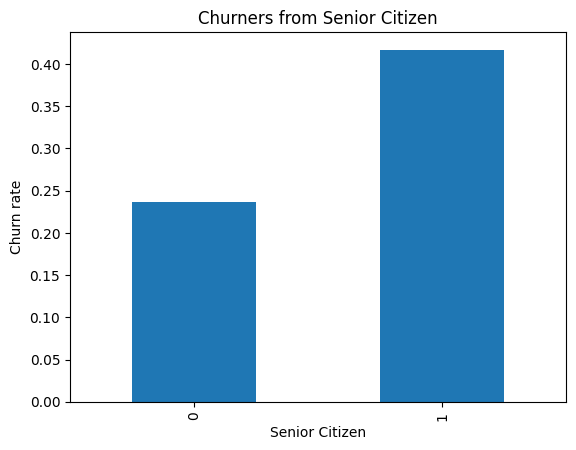

In [ ]:
churn_senior.plot(kind='bar')
plt.xlabel("Senior Citizen")
plt.ylabel("Churn rate")
plt.title("Churners from Senior Citizen")
plt.show()

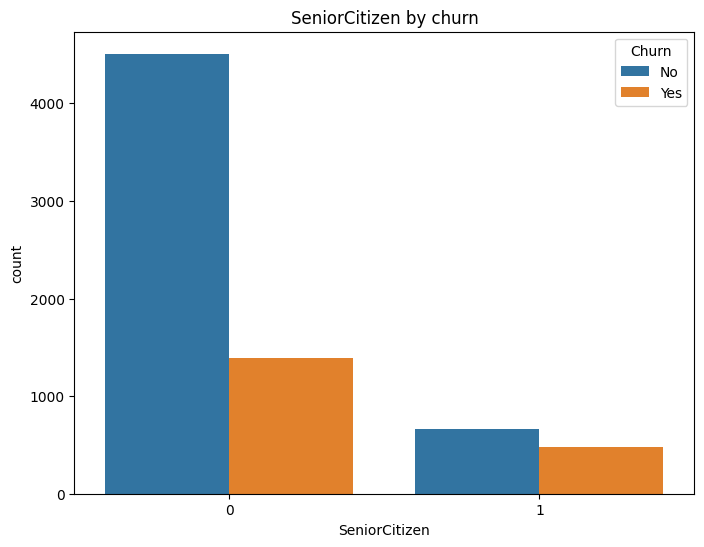

In [ ]:
plt.figure(figsize=(8,6))
sns.countplot(data=customer_df, x='SeniorCitizen', hue='Churn')
plt.title("SeniorCitizen by churn")
plt.show()

### Performing Chi2 test as to estimate seniorcitizen

Null hypotheses H0: Churn and seniorcitizen is independent

Alternative hypotheses H1: Churn and seniorcitizen are not indepedent

In [ ]:
ct_senior = pd.crosstab(customer_df['SeniorCitizen'], customer_df['Churn'])
ct_senior

Churn,No,Yes
SeniorCitizen,,
0,4508,1393
1,666,476


In [ ]:
chi2_senior, p_senior, dof_senior, expected_senior = chi2_contingency(ct_senior)
print("Chi2 statistics:", chi2_senior)
print("Pvalue :", p_senior)
print("Degrees of freedom:", dof_senior)
print("\nExpected (If independent):\n", np.round(expected_senior, 1))
print("\nRejecting null hypothesis that both are independent:", p_senior < 0.05)


Chi2 statistics: 159.42630036838742
Pvalue : 1.510066805092378e-36
Degrees of freedom: 1

Expected (If independent):
 [[4335.1 1565.9]
 [ 838.9  303.1]]

Rejecting null hypothesis that both are independent: True


In [ ]:
observed_senior = ct_senior.iloc[:, :2].values
observed_senior

array([[4508, 1393],
       [ 666,  476]])

### Phi effect size

In [ ]:
obs_snr = ct_senior.iloc[:, :2].to_numpy()
raw_total_snr = obs_snr.sum(axis=1)
col_total_snr = obs_snr.sum(axis=0)
N = obs_snr.sum()

pearson_snr = pearson_res(obs_snr, expected_senior)
std_res_snr = haberman_res(obs_snr, expected_senior,
                           raw_total_snr, col_total_snr,
                           N)

pearson_snr, std_res_snr

(array([[ 2.62674179, -4.37044787],
        [-5.97100093,  9.93472157]]),
 array([[ 12.66302222,  -5.57067233],
        [-28.78505903,  12.66302222]]))

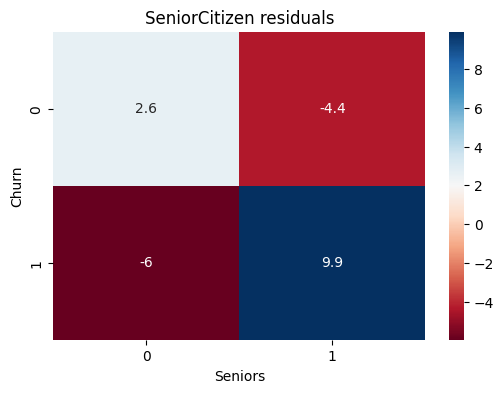

In [ ]:
plt.figure(figsize=(6,4))
sns.heatmap(data=pearson_snr, annot=True, cmap='RdBu')
plt.xlabel("Seniors")
plt.ylabel("Churn")
plt.title("SeniorCitizen residuals")
plt.show()

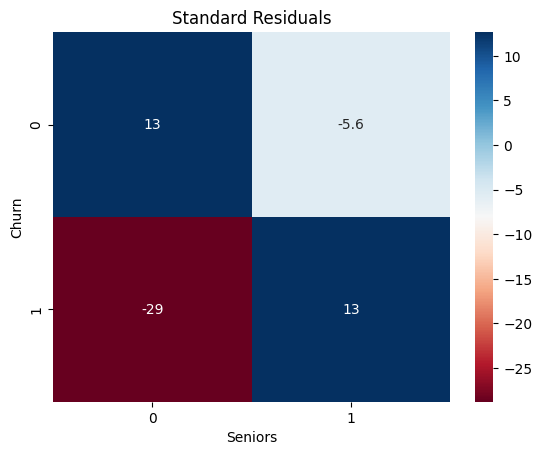

In [ ]:
sns.heatmap(data=std_res_snr, annot=True, cmap='RdBu')
plt.title("Standard Residuals")
plt.xlabel("Seniors")
plt.ylabel("Churn")
plt.show()

In [ ]:
N = ct_senior.to_numpy().sum()
phi = np.sqrt(chi2_senior / N)
print("Effect size:", phi)

Effect size: 0.15045309974200427


### Wilson CI

In [ ]:
ct_senior['total'] = ct_senior.sum(axis=1)
ct_senior['Churn rate'] = ct_senior['Yes'] / ct_senior['total']
ct_senior

Churn,No,Yes,total,Churn rate
SeniorCitizen,,,,
0,4508,1393,5901,0.236062
1,666,476,1142,0.416813


In [ ]:
CI_senior = ct_senior.apply(lambda row: proportion_confint(row['Yes'], row['total'], method='wilson'),
                            axis=1)
ct_senior['CI Low'] = [c[0] for c in CI_senior]
ct_senior['CI High'] = [c[1] for c in CI_senior]
ct_senior

Churn,No,Yes,total,Churn rate,CI Low,CI High
SeniorCitizen,,,,,,
0,4508,1393,5901,0.236062,0.225401,0.247066
1,666,476,1142,0.416813,0.388543,0.445640


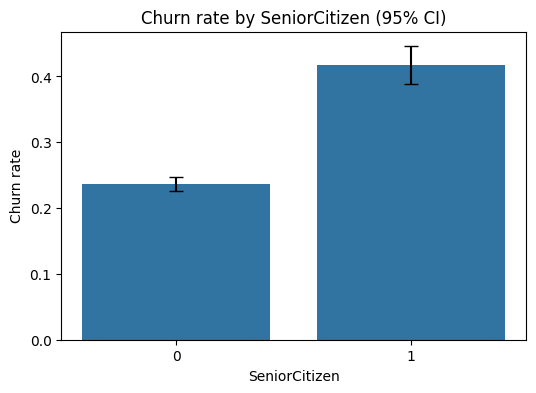

In [ ]:
plt.figure(figsize=(6,4))
sns.barplot(x=ct_senior.index, y=ct_senior['Churn rate'])
plt.errorbar(x=range(len(ct_senior)), y=ct_senior['Churn rate'],
             yerr=[ct_senior['Churn rate'] - ct_senior['CI Low'], ct_senior['CI High'] - ct_senior['Churn rate']],
             fmt='none', color='k', capsize=5)
plt.title("Churn rate by SeniorCitizen (95% CI)")
plt.show()

In [ ]:
count_snr = np.array([ct_senior.loc[1, 'Yes'], ct_senior.loc[0, 'Yes']])
nobs_snr = np.array([ct_senior.loc[1, 'total'], ct_senior.loc[0, 'total']])
stat_snr, p_snr = proportions_ztest(count_snr, nobs_snr)
print("Pairwise proportion statistic:", stat_snr)
print("Pvalue:", p_snr)

Pairwise proportion statistic: 12.663022223987696
Pvalue: 9.477903507376036e-37


### OddsRatio and CI for oddsRatio

In [ ]:
from statsmodels.stats.contingency_tables import Table2x2

table = Table2x2(observed_senior)
print("Odds ratio:", table.oddsratio)
print("Odds ratio 95% CI:", table.oddsratio_confint())

Odds ratio: 2.312946111941087
Odds ratio 95% CI: (np.float64(2.0267447042238405), np.float64(2.6395626965716534))


From performing deep analysis and tests, `SeniorCitizen` has none-seniors as more (84% almost) compared to seniors(16%). So among the churners more in non-seniors, but as non-seniors is large it is still a 24% only. But when comes to seniors it is 41% churners. By taking chi square test, there is dependency for the feature and churn. The CI wilson tells no overlapping and thus distinguishable. Phi value of 0.15 tell it is not a very string predictor for churn. Pairwise proportion test confirms the estimation as seniorcitizen is a predictor for churn. The odds ratio tells that 2.3 time more churners in seniors than non-seniors.

`Insights`: As seniors shows more churning, but due to more imbalance in sample, it considers as moderate predictor and can keep it as a feature for predictor.

## Looking onto partner

In [ ]:
customer_df['Dependents'].unique()

array(['No', 'Yes'], dtype=object)

In [ ]:
partner_rate = customer_df.groupby('Partner')['Churn'].apply(lambda x: (x=='Yes').mean())
partner_rate

,Churn
Partner,
No,0.329580
Yes,0.196649


##

ine', 'bar', 'barh', 'kde', 'density', 'area', 'hist', 'box', 'pie', 'scatter', 'hexbin

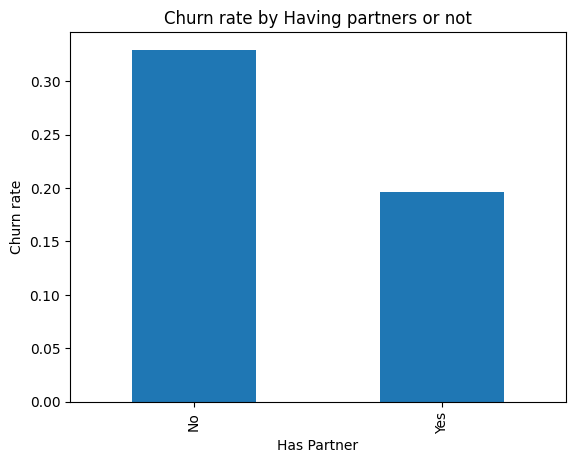

In [ ]:
partner_rate.plot(kind='bar')
plt.title("Churn rate by Having partners or not")
plt.xlabel("Has Partner")
plt.ylabel("Churn rate")
plt.show()

In [ ]:
ct_ptr = pd.crosstab(customer_df['Partner'], customer_df['Churn'])
ct_ptr

Churn,No,Yes
Partner,,
No,2441,1200
Yes,2733,669


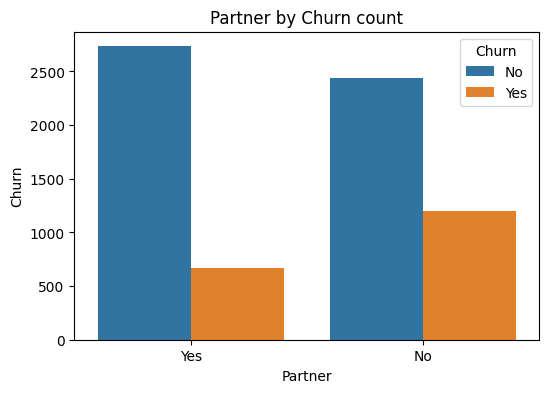

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(data=customer_df, x='Partner', hue='Churn')
plt.title("Partner by Churn count")
plt.xlabel("Partner")
plt.ylabel("Churn")
plt.show()

Chi2 test for dependency between Churn and Partner

Null Hypotheses H0: Churn and Partner are independent

Alternative hypotheses H1: Churn and Partner are not independent

In [ ]:
chi2_pt, p_pt, dof_pt, expected_pt = chi2_contingency(ct_ptr)
print("Chi2 statistic value:", chi2_pt)
print('Degrees of freedom:', dof_pt)
print("Pvalue:", p_pt)
print("\nExpected Contigency table (if independent):", expected_pt)

Chi2 statistic value: 158.7333820309922
Degrees of freedom: 1
Pvalue: 2.1399113440759935e-36

Expected Contigency table (if independent): [[2674.78830044  966.21169956]
 [2499.21169956  902.78830044]]


In [ ]:
print("Rejecting the null hypotheses:", p_pt < 0.05)

Rejecting the null hypotheses: True


### Residuals

In [ ]:
raw_residual_ptr = ct_ptr - expected_pt
print("Raw residuals for Partner:\n\n", np.round(raw_residual_ptr,1))

Raw residuals for Partner:

 Churn       No    Yes
Partner              
No      -233.8  233.8
Yes      233.8 -233.8


In [ ]:
obs_ptr = ct_ptr.values
row_total = obs_ptr.sum(axis=1)
col_total = obs_ptr.sum(axis=0)
N = obs_ptr.sum()

pearson_res_pt = pearson_res(obs_ptr, expected_pt)
std_residuals_pt = haberman_res(obs_ptr, expected_pt,
                             row_total, col_total,
                             N)

print("Pearson Residuals:", np.round(pearson_res_pt))
print("Standrad  Residuals:", np.round(std_residuals_pt))

Pearson Residuals: [[-5.  8.]
 [ 5. -8.]]
Standrad  Residuals: [[-13.  12.]
 [ 13. -13.]]


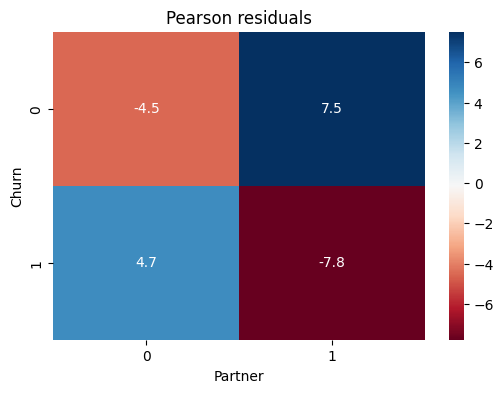

In [ ]:
plt.figure(figsize=(6,4))
sns.heatmap(data=pearson_res_pt, annot=True, cmap='RdBu')
plt.xlabel("Partner")
plt.ylabel("Churn")
plt.title("Pearson residuals")
plt.show()

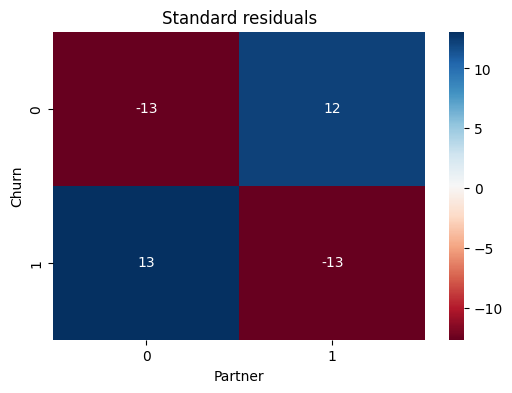

In [ ]:
plt.figure(figsize=(6,4))
sns.heatmap(data=std_residuals_pt, annot=True, cmap='RdBu')
plt.xlabel("Partner")
plt.ylabel("Churn")
plt.title("Standard residuals")
plt.show()

### Phi for effect

In [ ]:
N_ptr = ct_ptr.to_numpy().sum()
phi_ptr = np.sqrt(chi2_pt/N_ptr)
print("The effect size of Partner for Churn using Phi:", phi_ptr)

The effect size of Partner for Churn using Phi: 0.15012578474988478


### Wilson CI

In [ ]:
ct_ptr['total'] = ct_ptr.sum(axis=1)
ct_ptr['Churn rate'] = ct_ptr['Yes'] / ct_ptr['total']
ct_ptr

Churn,No,Yes,total,Churn rate
Partner,,,,
No,2441,1200,3641,0.329580
Yes,2733,669,3402,0.196649


In [ ]:
CI_ptr = ct_ptr.apply(lambda row: proportion_confint(row['Yes'], row['total'], method='wilson'),
                            axis=1)
ct_ptr['CI Low'] = [c[0] for c in CI_ptr]
ct_ptr['CI High'] = [c[1] for c in CI_ptr]
ct_ptr

Churn,No,Yes,total,Churn rate,CI Low,CI High
Partner,,,,,,
No,2441,1200,3641,0.329580,0.314498,0.345021
Yes,2733,669,3402,0.196649,0.183638,0.210344


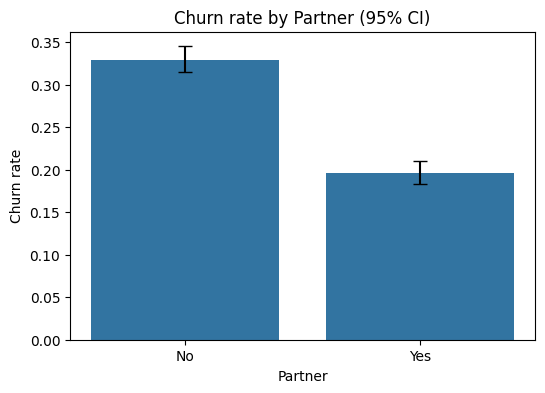

In [ ]:
plt.figure(figsize=(6,4))
sns.barplot(x=ct_ptr.index, y=ct_ptr['Churn rate'])
plt.errorbar(x=range(len(ct_ptr)), y=ct_ptr['Churn rate'],
             yerr=[ct_ptr['Churn rate'] - ct_ptr['CI Low'], ct_ptr['CI High'] - ct_ptr['Churn rate']],
             fmt='none', color='k', capsize=5)
plt.title("Churn rate by Partner (95% CI)")
plt.show()

### Pairwise proportion test

In [ ]:
ct_ptr

Churn,No,Yes,total,Churn rate,CI Low,CI High
Partner,,,,,,
No,2441,1200,3641,0.329580,0.314498,0.345021
Yes,2733,669,3402,0.196649,0.183638,0.210344


In [ ]:
count_ptr = np.array([ct_ptr.loc['Yes', 'Yes'], ct_ptr.loc['No', 'Yes']])
nobs_ptr = np.array([ct_ptr.loc['Yes', 'total'], ct_ptr.loc['No', 'total']])
stat_ptr, p_ptr = proportions_ztest(count_ptr, nobs_ptr)
print("Pairwise proportion statistic for Partner by Churn:", stat_ptr)
print("Pvalue:", p_ptr)

Pairwise proportion statistic for Partner by Churn: -12.62594663510133
Pvalue: 1.519036620099678e-36


In [ ]:
table_ptr = Table2x2(obs_ptr)
odds_ratio_ptr = table_ptr.oddsratio
odds_ratio_ci = table_ptr.oddsratio_confint()
print("Odds ratio for partner:", odds_ratio_ptr)
print("Odds ratio 95% CI partner:", odds_ratio_ci)

Odds ratio for partner: 0.49793541895353094
Odds ratio 95% CI partner: (np.float64(0.44642868545505604), np.float64(0.5553847445884831))


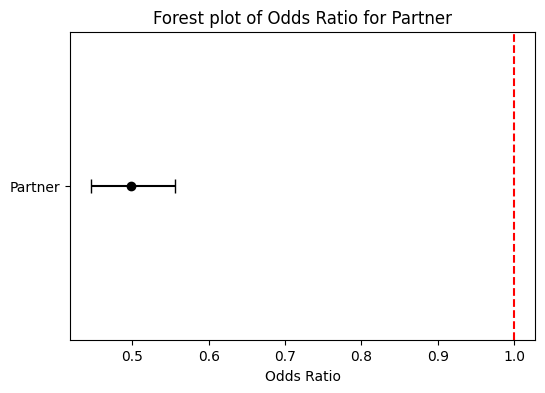

In [ ]:
odds_ratio = [odds_ratio_ptr]
features_ptr = ['Partner']
ci_low = np.array(odds_ratio_ci[0])
ci_high = np.array(odds_ratio_ci[1])

fig, ax = plt.subplots(figsize=(6,4))
ax.errorbar(odds_ratio, features_ptr,
            xerr=[[odds_ratio[0] - ci_low], [ci_high- odds_ratio[0]]],
            fmt='o', color='black', capsize=5)

ax.axvline(x=1, color='red', linestyle='--')
ax.set_xlabel("Odds Ratio")
ax.set_title("Forest plot of Odds Ratio for Partner")

plt.show()

The feature `Partners` estimated as a predictor for churn. When performed test of chi-square, the independence is rejected and indicated a relation between partner and churn. Through calculation of residuals of raw, pearson and standard residuals(Haberman) it was noticed that the group with partner has less churn than expected, while no partners group has more churn than expected. From Wilson Ci, the CI doesn't overlapped, so the difference is significant. From pairwise propotion test it was clear that the two groups are distinguishable.By taking oddsRatio the with partner group are half less likely to churn. But the without partner group are more likely to churn.

Insight: More focus and campaign needed for without partner group with some offers or long term bonus.

##

## Moving on to `Dependents` feature

In [ ]:
customer_df['Dependents'].unique()

array(['No', 'Yes'], dtype=object)

In [ ]:
depedends_rate = customer_df.groupby('Dependents')['Churn'].apply(lambda x: (x=='Yes').mean())
depedends_rate

,Churn
Dependents,
No,0.312791
Yes,0.154502


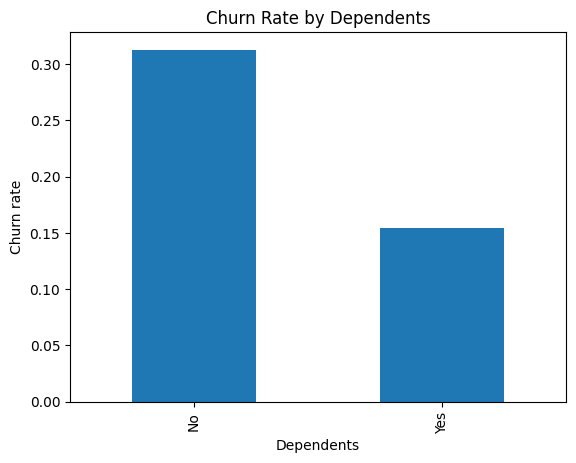

In [ ]:
depedends_rate.plot(kind='bar')
plt.xlabel("Dependents")
plt.ylabel("Churn rate")
plt.title("Churn Rate by Dependents")
plt.show()

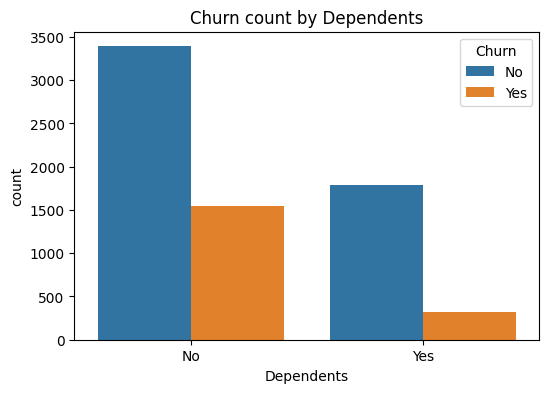

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(data=customer_df, x='Dependents', hue='Churn')
plt.title("Churn count by Dependents")
plt.show()

### Chi square test for Dependents and Churn

Null Hypotheses H0: The Dependents and Churn are independent

Alternate Hypotheses H1: The Dependents and Churn are not independent

In [ ]:
ct_dep = pd.crosstab(customer_df['Dependents'], customer_df['Churn'],
                     margins=True)
ct_dep

Churn,No,Yes,All
Dependents,,,
No,3390,1543,4933
Yes,1784,326,2110
All,5174,1869,7043


In [ ]:
chi2_dep, p_dep, dof_dep, expected_dep = chi2_contingency(ct_dep.iloc[:-1, :-1])
print("Chi2 statistic for Dependency:", chi2_dep)
print("Degrees of freedom for Dependency:", dof_dep)
print("P value for Dependency:", p_dep)
print("\nExpected Contigency table (if independent):\n", np.round(expected_dep,1))

Chi2 statistic for Dependency: 189.12924940423474
Degrees of freedom for Dependency: 1
P value for Dependency: 4.9249216612154196e-43

Expected Contigency table (if independent):
 [[3623.9 1309.1]
 [1550.1  559.9]]


In [ ]:
print("Rejecting Null hypotheses:", p_dep < 0.05)

Rejecting Null hypotheses: True


In [ ]:
N_dep = ct_dep.iloc[:-1, :-1].to_numpy().sum()
phi_dep = np.sqrt(chi2_dep/N_dep)
print("Effect size of Department for Churn using phi:", phi_dep)

Effect size of Department for Churn using phi: 0.1638703967886369


### Residuals

In [ ]:
raw_residuals_dep = ct_dep.iloc[:-1, :-1] - expected_dep
print("Raw residuals:", np.round(raw_residuals_dep,1))

Raw residuals: Churn          No    Yes
Dependents              
No         -233.9  233.9
Yes         233.9 -233.9


In [ ]:
obs_dep = ct_dep.iloc[:-1, :-1].to_numpy()
pearson_dep = pearson_res(obs_dep, expected_dep)
print("Pearson residual for dependents:", pearson_dep)

Pearson residual for dependents: [[-3.88594624  6.46554815]
 [ 5.94170545 -9.88597892]]


In [ ]:
col_total_dep = ct_dep.loc["All", :][:-1].to_numpy()
row_total_dep = ct_dep.loc[:, "All"][:-1].to_numpy()
N = obs_dep.sum()
std_res_dep = haberman_res(obs_dep, expected_dep,
                           row_total_dep, col_total_dep,
                           N)
std_res_dep

array([[-13.78188427,   9.01351672],
       [ 21.07283316, -13.78188427]])

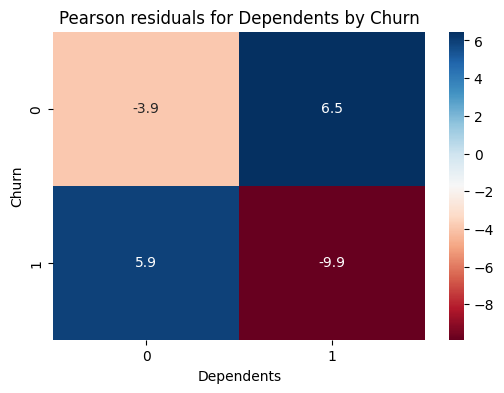

In [ ]:
plt.figure(figsize=(6,4))
sns.heatmap(data=pearson_dep, annot=True, cmap='RdBu')
plt.xlabel("Dependents")
plt.ylabel("Churn")
plt.title("Pearson residuals for Dependents by Churn")
plt.show()

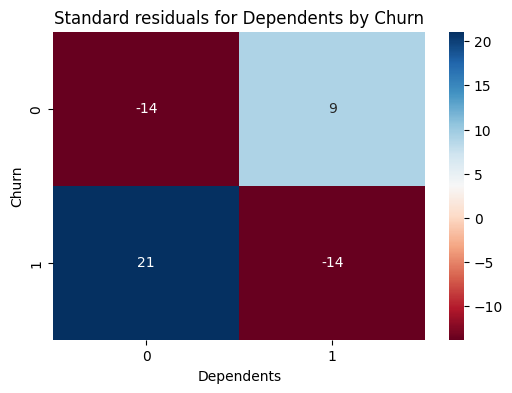

In [ ]:
plt.figure(figsize=(6,4))
sns.heatmap(data=std_res_dep, annot=True, cmap='RdBu')
plt.xlabel("Dependents")
plt.ylabel("Churn")
plt.title("Standard residuals for Dependents by Churn")
plt.show()

In [ ]:
contr = pearson_dep ** 2
pct_contr = contr / contr.sum() * 100
print("Contributions of each cell:\n", pct_contr)

Contributions of each cell:
 [[ 7.95016935 22.00865501]
 [18.58681773 51.45435791]]


In [ ]:
ct_dep['Churn rate'] = ct_dep['Yes'] / ct_dep['All']
ct_dep

Churn,No,Yes,All,Churn rate
Dependents,,,,
No,3390,1543,4933,0.312791
Yes,1784,326,2110,0.154502
All,5174,1869,7043,0.265370


In [ ]:
CI_dep = ct_dep.apply(lambda row: proportion_confint(row['Yes'], row['All'], method='wilson'),
                            axis=1)
ct_dep['CI Low'] = [c[0] for c in CI_dep]
ct_dep['CI High'] = [c[1] for c in CI_dep]
ct_dep

Churn,No,Yes,All,Churn rate,CI Low,CI High
Dependents,,,,,,
No,3390,1543,4933,0.312791,0.300003,0.325871
Yes,1784,326,2110,0.154502,0.139710,0.170551
All,5174,1869,7043,0.265370,0.255188,0.275807


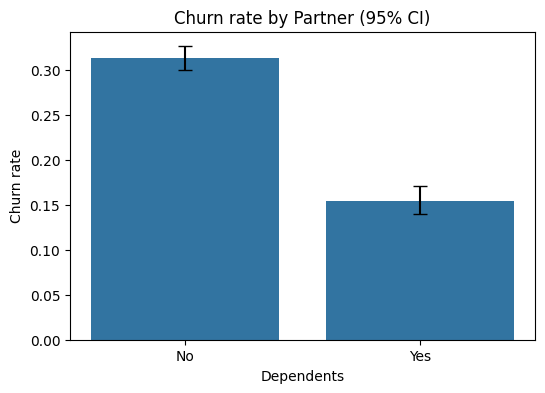

In [ ]:
plt.figure(figsize=(6,4))
sns.barplot(x=ct_dep[:-1].index, y=ct_dep['Churn rate'][:-1])
plt.errorbar(x=range(len(ct_dep[:-1])), y=ct_dep['Churn rate'][:-1],
             yerr=[ct_dep['Churn rate'][:-1] - ct_dep['CI Low'][:-1], ct_dep['CI High'][:-1] - ct_dep['Churn rate'][:-1]],
             fmt='none', color='k', capsize=5)
plt.title("Churn rate by Partner (95% CI)")
plt.show()

In [ ]:
count_dep = np.array([ct_dep.loc['No', 'Yes'], ct_dep.loc['Yes', 'Yes']])
nobs_dep = np.array([ct_dep.loc['No', 'All'], ct_dep.loc['Yes', 'All']])
stat_dep, p_dep = proportions_ztest(count_dep, nobs_dep)
print("Pairwise proportion statistic for Dependents by Churn:", stat_dep)
print("Pvalue:", p_dep)

Pairwise proportion statistic for Dependents by Churn: 13.781884265707227
Pvalue: 3.276082809397685e-43


In [ ]:
table_dep = Table2x2(obs_dep)
odds_ratio_dep = table_dep.oddsratio
odds_ratio_dep_ci = table_dep.oddsratio_confint()
print("Odds ratio for partner:", odds_ratio_dep)
print("Odds ratio 95% CI partner:", odds_ratio_dep_ci)

Odds ratio for partner: 0.4014731653729122
Odds ratio 95% CI partner: (np.float64(0.35164697525075667), np.float64(0.4583594168543872))


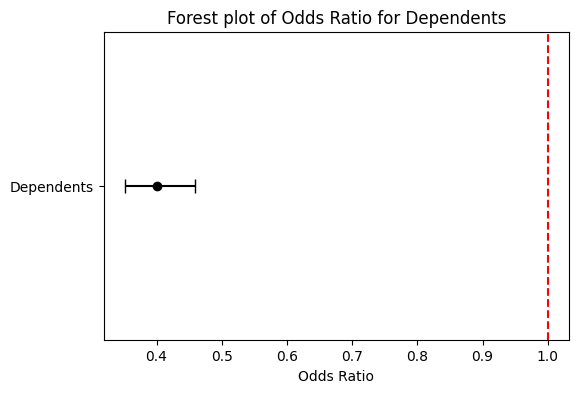

In [ ]:
features_dep = ['Dependents']
ci_low = odds_ratio_dep_ci[0]
ci_high = odds_ratio_dep_ci[1]

fig, ax = plt.subplots(figsize=(6,4))
ax.errorbar([odds_ratio_dep], features_dep,
            xerr=[[odds_ratio_dep - ci_low], [ci_high- odds_ratio_dep]],
            fmt='o', color='black', capsize=5)

ax.axvline(x=1, color='red', linestyle='--')
ax.set_xlabel("Odds Ratio")
ax.set_title("Forest plot of Odds Ratio for Dependents")

plt.show()

The estimate was on the feature `Dependents` is a predictive feature for `Churn`. For this, from the bar plot with churn rate and count plot with churn and no-churn, got to know an initial insight of the data spread. The independence of the both is rejected by chi-square test and from the residuals it was clear that more churners is inside the no dependents group. The phi of 15% is a moderate effect, but when approached pairwise test it was clear about the difference in the groups. The wilson CI was non-overlapping and thus became sure about distinguishable.Taking oddsRatio made the clear view that the with dependenst group has half churners when compared to without group.

Insight: The `Dependents` is a good predictive feature for modelling. The group without dependents should be focused more with some strategies to reduce churn among the group.